In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geojson import Point, Feature, FeatureCollection, dump

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import KMeans  

from sklearn.metrics import silhouette_score

from scipy.spatial.distance import cdist

%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 100)

In [2]:
ph = gpd.read_file('data/Philippines_Solar/Barangays_Solar_Data.geojson')
ph.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,NL_NAME_3,VARNAME_3,TYPE_3,ENGTYPE_3,PROVINCE,REGION,GHI_mean,GHI_min,GHI_max,DIF_mean,DIF_min,DIF_max,DNI_mean,DNI_min,DNI_max,GTI_mean,GTI_min,GTI_max,OPTA_mean,OPTA_min,OPTA_max,PVOUT_mean,PVOUT_min,PVOUT_max,TEMP_mean,TEMP_min,TEMP_max,geometry
0,177,PHL,Philippines,1,Abra,16,Manabo,172,San Jose Norte,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1972.681335,1912.448975,1983.307983,732.932439,715.890015,738.536011,1772.840666,1606.734985,1799.222046,2075.214970,2010.701050,2089.594971,20.000000,20.0,20.0,1623.170833,1609.291992,1631.937012,27.330769,26.400000,27.799999,"MULTIPOLYGON (((120.70043 17.45648, 120.70312 ..."
1,177,PHL,Philippines,1,Abra,16,Manabo,173,San Jose Sur,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1967.001718,1944.225952,1977.098022,733.630674,724.656006,736.708984,1765.331617,1709.005005,1787.167969,2067.367113,2042.843018,2081.560059,20.000000,20.0,20.0,1617.967421,1606.369019,1624.996948,27.398231,26.799999,27.799999,"MULTIPOLYGON (((120.74783 17.44496, 120.74841 ..."
2,177,PHL,Philippines,1,Abra,16,Manabo,174,San Juan Norte,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1966.958687,1939.478027,1976.733032,738.551295,729.039001,745.474976,1762.934679,1699.508057,1793.011963,2069.879671,2039.191040,2082.290039,20.008457,20.0,21.0,1622.878809,1611.848022,1640.703003,27.040000,25.600000,27.799999,"MULTIPOLYGON (((120.69788 17.43542, 120.70522 ..."
3,177,PHL,Philippines,1,Abra,16,Manabo,175,San Juan Sur,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1962.424855,1916.832031,1973.446045,739.567711,725.385986,745.840027,1754.541928,1660.426025,1787.167969,2065.036090,2014.718994,2079.732910,20.008484,20.0,21.0,1619.031331,1604.542969,1632.302002,26.766667,26.100000,27.600000,"MULTIPOLYGON (((120.66516 17.42832, 120.70497 ..."
4,177,PHL,Philippines,1,Abra,16,Manabo,176,San Ramon East,None,None,Barangay,Village,Abra,Cordillera Administrative Region (CAR),1903.905352,1811.640015,1962.123047,751.609724,736.708984,772.504028,1642.933283,1465.748047,1759.774048,1998.892135,1897.473999,2064.758057,20.000000,20.0,20.0,1570.199021,1535.510986,1603.447998,26.408823,24.600000,27.700001,"MULTIPOLYGON (((120.70567 17.42277, 120.76253 ..."


In [3]:
nan_index = ph.index[ph.PVOUT_mean.isnull()].values
# Impute based on Location
for index in nan_index:
    loc_name = ph.loc[index,"NAME_2"]
    imputed_value = ph[ph['NAME_2'] == loc_name].mean().values[0]
    ph.loc[index,'PVOUT_mean'] = imputed_value

In [4]:
pv_out = ph['PVOUT_mean']
pv_out = pv_out.to_numpy()
pv_out = pv_out.reshape(-1,1)
scaler = RobustScaler()
pv_out= scaler.fit_transform(pv_out)

In [5]:
distortions = []
distortion_map = {}

inertias = []
inertia_map = {}

silhouette_scores = []

K = range(2, 20)
 
for k in K:
    # Building and fitting the model
    kmeans = KMeans(n_clusters = k, max_iter=300, random_state = 1234)
    kmeans.fit(pv_out)
    
    # Distortions 
    distortions.append(sum(np.min(cdist(pv_out, kmeans.cluster_centers_,
                                        'euclidean'), axis=1)) / pv_out.shape[0])
    distortion_map[k] = sum(np.min(cdist(pv_out, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / pv_out.shape[0]
    
    # Inertia
    inertias.append(kmeans.inertia_)
    inertia_map[k] = kmeans.inertia_
    
    pred_clusters = kmeans.predict(pv_out)
    silhouette = silhouette_score(pv_out,pred_clusters)
    silhouette_scores.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(k,silhouette))

Silhouette score for number of cluster(s) 2: 0.5541911325777025
Silhouette score for number of cluster(s) 3: 0.5342510300321166
Silhouette score for number of cluster(s) 4: 0.5333086854911331
Silhouette score for number of cluster(s) 5: 0.5445389661974596
Silhouette score for number of cluster(s) 6: 0.5230221093503311
Silhouette score for number of cluster(s) 7: 0.5248068866111691
Silhouette score for number of cluster(s) 8: 0.5281819738135237
Silhouette score for number of cluster(s) 9: 0.5227202364101803
Silhouette score for number of cluster(s) 10: 0.5220082401061749
Silhouette score for number of cluster(s) 11: 0.5276733105854646
Silhouette score for number of cluster(s) 12: 0.5306799463530241
Silhouette score for number of cluster(s) 13: 0.5315523517014485
Silhouette score for number of cluster(s) 14: 0.5263420491289653
Silhouette score for number of cluster(s) 15: 0.5266055478655641
Silhouette score for number of cluster(s) 16: 0.527614133343009
Silhouette score for number of clu

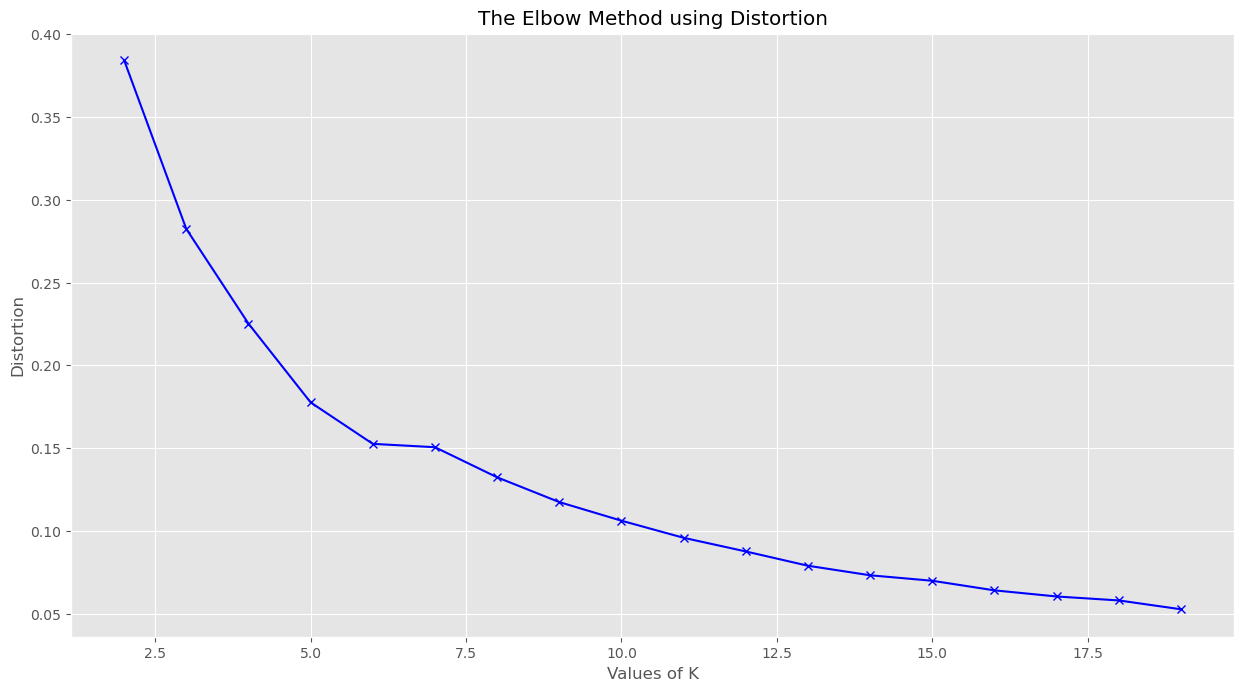

In [8]:
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

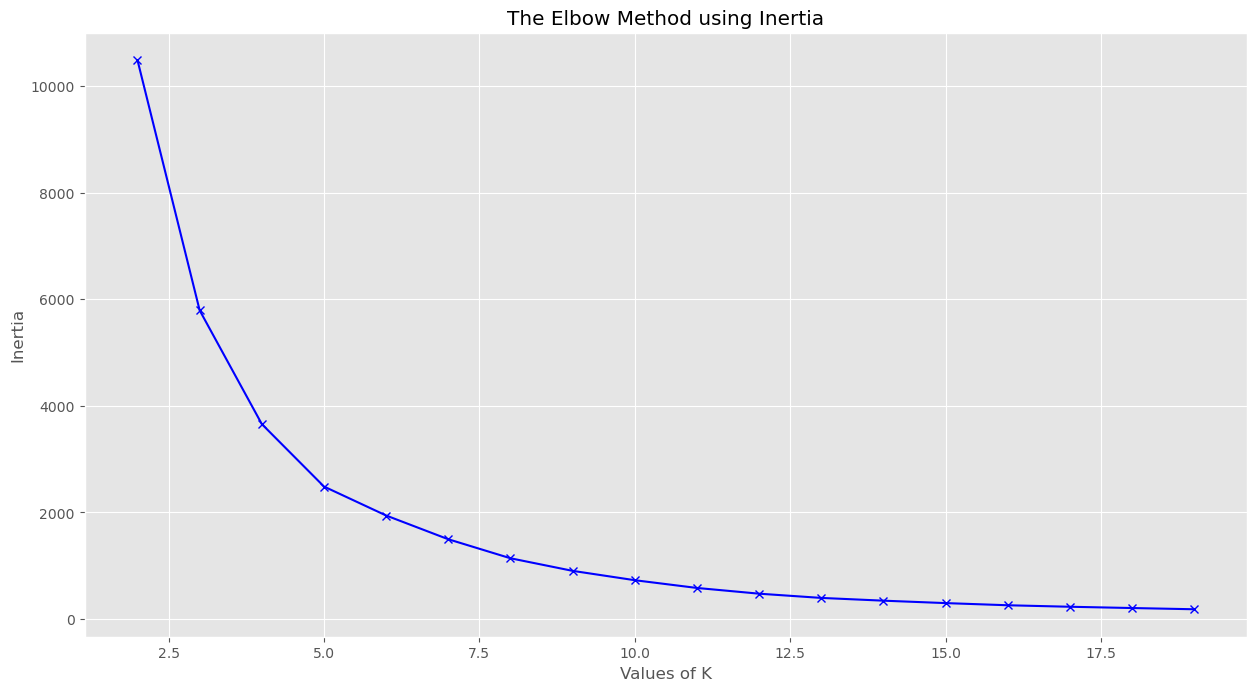

In [9]:
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

#### K = 5, Silhouette Score = 0.5445389661974596

In [10]:
km_5 = KMeans(n_clusters=5, max_iter=300, random_state = 1234)
km_5.fit(pv_out)

KMeans(n_clusters=5, random_state=1234)

In [11]:
ph_cluster_5 = ph.copy()
ph_cluster_5['Cluster'] = km_5.labels_ + 1

Text(0.5, 1.0, 'Barangays Clustered for PVOUT')

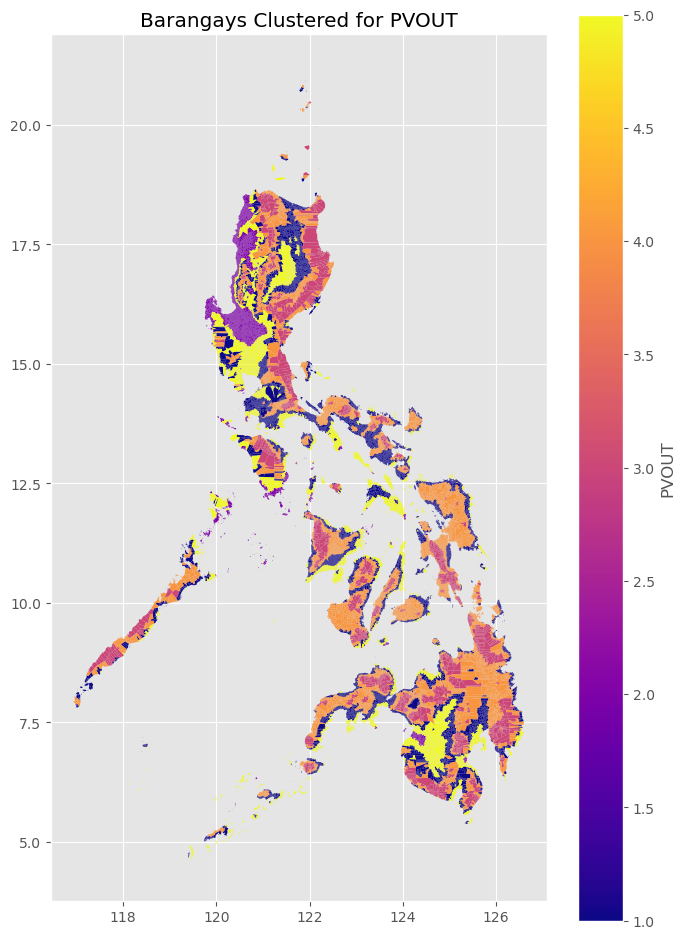

In [12]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_5.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Barangays Clustered for PVOUT')

In [13]:
ph_cluster_5.to_file(driver='GeoJSON', filename = "data/results/kmeans/5_clusters/ph_clustered.geojson")

In [14]:
ph_cluster_5.to_file(driver = 'ESRI Shapefile', filename= "data/results/kmeans/5_clusters/ph_clustered.shp")

In [15]:
pv_out_per_cluster_summary = ph_cluster_5.groupby('Cluster').agg({'PVOUT_mean': ['mean', 'min', 'max']})
pv_out_per_cluster_summary

PVOUT_mean                          
                mean          min          max
Cluster                                       
1        1428.941756  1395.346008  1464.237079
2        1606.613198  1553.113374  1695.307983
3        1260.622247   177.000000  1310.955200
4        1361.592731  1310.966515  1395.328003
5        1499.141078  1464.277943  1553.088776

In [16]:
pv_out_per_cluster_summary.to_csv("data/results/kmeans/5_clusters/ph_clusters_summary.csv")

#### K = 6, Silhouette Score = 0.5230221093503311

In [17]:
km_6 = KMeans(n_clusters=6, max_iter=300, random_state = 1234)
km_6.fit(pv_out)

KMeans(n_clusters=6, random_state=1234)

In [18]:
ph_cluster_6 = ph.copy()
ph_cluster_6['Cluster'] = km_6.labels_ + 1

Text(0.5, 1.0, 'Barangays Clustered for PVOUT')

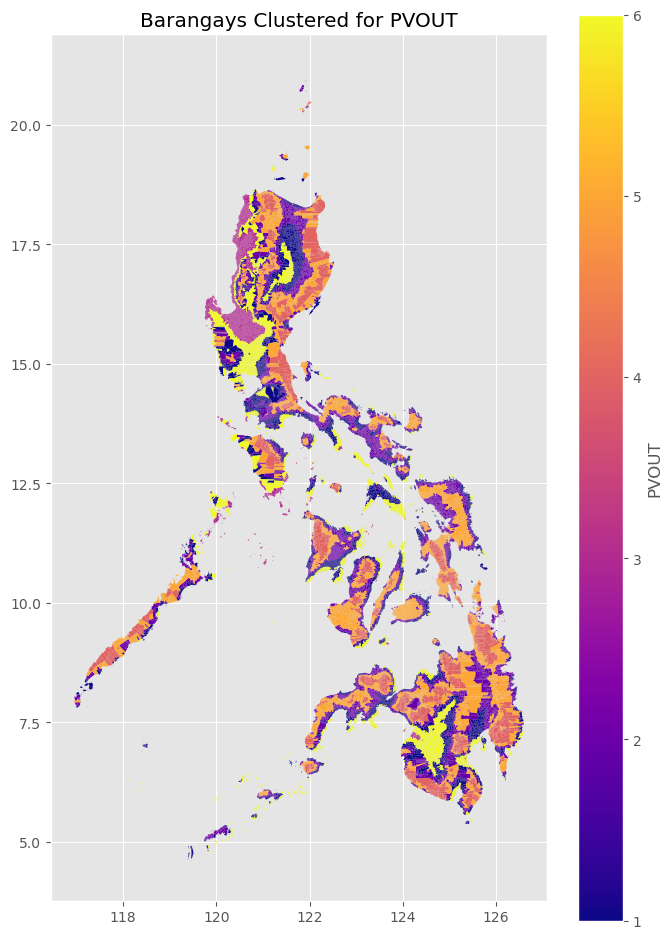

In [19]:
fig, ax = plt.subplots(figsize=(8,12))
ph_cluster_6.plot(column= 'Cluster', ax=ax, legend = True, cmap='plasma', 
             legend_kwds = {'label':'PVOUT'})
plt.title('Barangays Clustered for PVOUT')

In [20]:
ph_cluster_6.to_file(driver='GeoJSON', filename = "data/results/kmeans/6_clusters/ph_clustered.geojson")

In [21]:
ph_cluster_6.to_file(driver = 'ESRI Shapefile', filename= "data/results/kmeans/6_clusters/ph_clustered.shp")

In [22]:
pv_out_per_cluster_summary = ph_cluster_6.groupby('Cluster').agg({'PVOUT_mean': ['mean', 'min', 'max']})
pv_out_per_cluster_summary

PVOUT_mean                          
                mean          min          max
Cluster                                       
1        1453.428042  1426.520410  1483.135363
2        1399.729668  1372.243958  1426.504232
3        1611.942227  1562.466382  1695.307983
4        1243.971525   177.000000  1294.446014
5        1344.470225  1294.498308  1372.218802
6        1513.293365  1483.149711  1562.448120

In [23]:
pv_out_per_cluster_summary.to_csv("data/results/kmeans/6_clusters/ph_clusters_summary.csv")